In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# (Improper) Functions Import

## Preprocessing Functions

In [2]:
from sklearn.preprocessing import StandardScaler

def std_scaler(df):
    """
    Scale the data with SKlearn StandardScaler
    """
    
    scaler = StandardScaler()
    
    col_to_scale_df = df.drop(columns=['ticker', 'date', '5TD_return', '10TD_return', '20TD_return'])
    col_to_scale = list(col_to_scale_df)
    
    scaled_df = df
    
    for col in col_to_scale:
        scaled_df[col] = scaler.fit_transform(scaled_df[[col]])
    
    return scaled_df

In [3]:
#Marcin's Function

def build_input_arrays(df, time_window=5, stride=3, input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal'] , target_col='5TD_return'):
    output_array = []
    target_array = []
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)
    for row in range(0, len(df), stride):
        df_slice = df_sorted.iloc[row: row + time_window]
        if df_slice.shape[0]==time_window:
            output_array.append(np.array(df_slice[input_cols].values))
            target_array.append(df_slice[target_col].iloc[0])
    return np.array(output_array), np.array(target_array)

In [4]:
#Ian's Function

def train_test_split(df, test_set_size='3Y'):
    """
    Split the preprocessed stock data file into a train and test dataset
    INPUT: the dataframe to be split, and size of the test set in months or years ('3M' or '2Y')
    OUTPUT: returns a train_set and test_set dataframe, index is set to the date
    
    EXAMPLE: train_set, test_set = train_test_split(input_df, '3Y')
    """
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d'))
    test_set = df.sort_values(by="date",ascending=True).set_index("date").last(test_set_size)
    train_set = df.drop(df.tail(len(test_set)).index).set_index("date")
    test_set.reset_index(inplace=True)
    train_set.reset_index(inplace=True)
    return train_set, test_set

## Visualisation Functions

In [5]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# LSTM Baseline Model

In [6]:
df = pd.read_csv('../raw_data/AAPL.csv')

## Preprocessing

### Scaling

In [7]:
df_scaled = std_scaler(df)

/home/bob/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bob/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
df_scaled.head()

,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return
0,AAPL,1984-10-24,0.339732,0.691188,0.486039,-0.187390,-1.599369,-0.430690,-0.734613,1.133141,0.056752,-0.167518,0.000989,-0.176569,-0.052010,-0.018263,-0.119206
1,AAPL,1984-10-25,-0.328390,0.037753,0.447752,-0.191682,-1.601392,-0.430637,-0.827636,0.816135,0.775435,-0.167443,-0.000470,-0.176080,-0.009378,-0.022156,-0.060181
2,AAPL,1984-10-26,-0.692953,-0.393761,0.119486,-0.194098,-1.602861,-0.430709,-0.918523,0.596235,1.273968,-0.167725,-0.002715,-0.175749,0.009726,-0.055397,-0.026218
3,AAPL,1984-10-29,-0.639442,-0.340923,-0.248323,-0.195472,-1.602213,-0.431008,-1.002919,0.523564,1.191167,-0.167893,-0.004164,-0.175518,0.000000,-0.025925,-0.003162
4,AAPL,1984-10-30,-0.416737,-0.122524,-0.305440,-0.197496,-1.601259,-0.431131,-1.103085,0.758533,0.997380,-0.167834,-0.004643,-0.175322,0.048060,-0.060959,0.035265


### Target Encoding for Classification

**Thresholds for transforming target variables into binary values:**
- 5 days returns > 0.0006
- 10 days returns > 0.0012
- for 20 days returns > 0.0024.

In [2]:
def thresholds_encoding(df, r5d=0.0006, same_thresholds=True, r10d=0.0012, r20d=0.0024):
    """
    Binary encode the 5, 10 and 20 days return columns according to the thresholds
    
    INPUT: dataframe with '5TD_return', '10TD_return' and '20TD_return' columns
    OUTPUT: dataframe with binary encoded aforementionned columns
    
    If the thresolds returns are the same on a yearly basis for the different period use:
                r10d = r5d * 2 
            and
                r20d = r10d * 2
            keep same_thresholds=True
        Otherwise, define manually r10d and r20d
    """
    wk_df = df.copy()
    
    if any(['5TD_return','10TD_return','20TD_return']) not in list(df):
        print('Missing return columns')
    
    elif same_thresholds:
        r10d = r5d * 2
        r20d = r10d * 2
    
    wk_df['5TD_return'] = wk_df['5TD_return'].apply(lambda x: 1 if x > r5d else 0)
    wk_df['10TD_return'] = wk_df['10TD_return'].apply(lambda x: 1 if x > r10d else 0)
    wk_df['20TD_return'] = wk_df['20TD_return'].apply(lambda x: 1 if x > r20d else 0)
    
    return wk_df


In [10]:
df_scaled.head(15)

,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return
0,AAPL,1984-10-24,0.339732,0.691188,0.486039,-0.187390,-1.599369,-0.430690,-0.734613,1.133141,0.056752,-0.167518,0.000989,-0.176569,-0.052010,-0.018263,-0.119206
1,AAPL,1984-10-25,-0.328390,0.037753,0.447752,-0.191682,-1.601392,-0.430637,-0.827636,0.816135,0.775435,-0.167443,-0.000470,-0.176080,-0.009378,-0.022156,-0.060181
2,AAPL,1984-10-26,-0.692953,-0.393761,0.119486,-0.194098,-1.602861,-0.430709,-0.918523,0.596235,1.273968,-0.167725,-0.002715,-0.175749,0.009726,-0.055397,-0.026218
3,AAPL,1984-10-29,-0.639442,-0.340923,-0.248323,-0.195472,-1.602213,-0.431008,-1.002919,0.523564,1.191167,-0.167893,-0.004164,-0.175518,0.000000,-0.025925,-0.003162
4,AAPL,1984-10-30,-0.416737,-0.122524,-0.305440,-0.197496,-1.601259,-0.431131,-1.103085,0.758533,0.997380,-0.167834,-0.004643,-0.175322,0.048060,-0.060959,0.035265
5,AAPL,1984-10-31,-0.519022,-0.231723,-0.247695,-0.199131,-1.602029,-0.431323,-1.197733,0.624318,1.038515,-0.167864,-0.005294,-0.175171,0.035598,-0.045126,0.022406
6,AAPL,1984-11-01,-0.400616,-0.744531,-0.391527,-0.200407,-1.601428,-0.431501,-1.285621,0.490461,0.896248,-0.167786,-0.005490,-0.175034,-0.012899,-0.051285,-0.012899
7,AAPL,1984-11-02,-0.512790,-0.896916,-0.667494,-0.200550,-1.601782,-0.431667,-1.331923,0.357326,1.133884,-0.167801,-0.005928,-0.174927,-0.064496,-0.064496,-0.019370
8,AAPL,1984-11-05,-0.626221,-1.622029,-1.162951,-0.203409,-1.603130,-0.431665,-1.413300,0.488386,0.861658,-0.167890,-0.006499,-0.174861,-0.025925,-0.113605,0.006534
9,AAPL,1984-11-06,0.392600,0.148261,-0.844791,-0.209523,-1.600248,-0.431192,-1.396791,0.972158,0.320397,-0.167109,-0.004343,-0.174643,-0.104020,-0.137667,-0.006154


In [11]:
clean_df = thresholds_encoding(df_scaled)
clean_df.head(15)

Missing return columns


,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return
0,AAPL,1984-10-24,0.339732,0.691188,0.486039,-0.187390,-1.599369,-0.430690,-0.734613,1.133141,0.056752,-0.167518,0.000989,-0.176569,0,0,0
1,AAPL,1984-10-25,-0.328390,0.037753,0.447752,-0.191682,-1.601392,-0.430637,-0.827636,0.816135,0.775435,-0.167443,-0.000470,-0.176080,0,0,0
2,AAPL,1984-10-26,-0.692953,-0.393761,0.119486,-0.194098,-1.602861,-0.430709,-0.918523,0.596235,1.273968,-0.167725,-0.002715,-0.175749,1,0,0
3,AAPL,1984-10-29,-0.639442,-0.340923,-0.248323,-0.195472,-1.602213,-0.431008,-1.002919,0.523564,1.191167,-0.167893,-0.004164,-0.175518,0,0,0
4,AAPL,1984-10-30,-0.416737,-0.122524,-0.305440,-0.197496,-1.601259,-0.431131,-1.103085,0.758533,0.997380,-0.167834,-0.004643,-0.175322,1,0,1
5,AAPL,1984-10-31,-0.519022,-0.231723,-0.247695,-0.199131,-1.602029,-0.431323,-1.197733,0.624318,1.038515,-0.167864,-0.005294,-0.175171,1,0,1
6,AAPL,1984-11-01,-0.400616,-0.744531,-0.391527,-0.200407,-1.601428,-0.431501,-1.285621,0.490461,0.896248,-0.167786,-0.005490,-0.175034,0,0,0
7,AAPL,1984-11-02,-0.512790,-0.896916,-0.667494,-0.200550,-1.601782,-0.431667,-1.331923,0.357326,1.133884,-0.167801,-0.005928,-0.174927,0,0,0
8,AAPL,1984-11-05,-0.626221,-1.622029,-1.162951,-0.203409,-1.603130,-0.431665,-1.413300,0.488386,0.861658,-0.167890,-0.006499,-0.174861,0,0,1
9,AAPL,1984-11-06,0.392600,0.148261,-0.844791,-0.209523,-1.600248,-0.431192,-1.396791,0.972158,0.320397,-0.167109,-0.004343,-0.174643,0,0,0


### Spliting Data to Train and Test set

In [12]:
train, test = train_test_split(clean_df)

In [13]:
train

,date,ticker,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return
0,1984-10-24,AAPL,0.339732,0.691188,0.486039,-0.187390,-1.599369,-0.430690,-0.734613,1.133141,0.056752,-0.167518,0.000989,-0.176569,0,0,0
1,1984-10-25,AAPL,-0.328390,0.037753,0.447752,-0.191682,-1.601392,-0.430637,-0.827636,0.816135,0.775435,-0.167443,-0.000470,-0.176080,0,0,0
2,1984-10-26,AAPL,-0.692953,-0.393761,0.119486,-0.194098,-1.602861,-0.430709,-0.918523,0.596235,1.273968,-0.167725,-0.002715,-0.175749,1,0,0
3,1984-10-29,AAPL,-0.639442,-0.340923,-0.248323,-0.195472,-1.602213,-0.431008,-1.002919,0.523564,1.191167,-0.167893,-0.004164,-0.175518,0,0,0
4,1984-10-30,AAPL,-0.416737,-0.122524,-0.305440,-0.197496,-1.601259,-0.431131,-1.103085,0.758533,0.997380,-0.167834,-0.004643,-0.175322,1,0,1
5,1984-10-31,AAPL,-0.519022,-0.231723,-0.247695,-0.199131,-1.602029,-0.431323,-1.197733,0.624318,1.038515,-0.167864,-0.005294,-0.175171,1,0,1
6,1984-11-01,AAPL,-0.400616,-0.744531,-0.391527,-0.200407,-1.601428,-0.431501,-1.285621,0.490461,0.896248,-0.167786,-0.005490,-0.175034,0,0,0
7,1984-11-02,AAPL,-0.512790,-0.896916,-0.667494,-0.200550,-1.601782,-0.431667,-1.331923,0.357326,1.133884,-0.167801,-0.005928,-0.174927,0,0,0
8,1984-11-05,AAPL,-0.626221,-1.622029,-1.162951,-0.203409,-1.603130,-0.431665,-1.413300,0.488386,0.861658,-0.167890,-0.006499,-0.174861,0,0,1
9,1984-11-06,AAPL,0.392600,0.148261,-0.844791,-0.209523,-1.600248,-0.431192,-1.396791,0.972158,0.320397,-0.167109,-0.004343,-0.174643,0,0,0


In [14]:
test

,date,ticker,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,5TD_return,10TD_return,20TD_return
0,2018-01-02,AAPL,-0.115982,-0.563834,-1.107581,1.462221,1.200120,0.592373,-1.247088,0.057201,0.528320,0.016138,-0.827784,0.249108,1,1,0
1,2018-01-03,AAPL,-0.122326,-0.575732,-0.988325,1.459970,1.198768,0.597758,-1.273753,0.584502,0.284100,0.009838,-0.682630,0.201775,1,1,0
2,2018-01-04,AAPL,0.046305,-0.242592,-0.492514,1.460785,1.199793,0.566801,-1.298513,0.436778,0.157557,0.030909,-0.484334,0.168343,1,1,0
3,2018-01-05,AAPL,0.417119,0.554563,-0.093956,1.462313,1.200875,0.566289,-1.257837,0.855829,-0.043357,0.112208,-0.144871,0.158709,1,1,0
4,2018-01-08,AAPL,0.265740,0.311507,0.222225,1.461406,1.199934,0.545682,-1.212497,0.745759,-0.180014,0.152283,0.002932,0.159437,1,1,0
5,2018-01-09,AAPL,0.248182,0.637638,0.535909,1.461645,1.198946,0.525535,-1.196313,0.557866,-0.113936,0.177758,0.077340,0.165381,1,0,0
6,2018-01-10,AAPL,0.236444,0.617769,0.558433,1.463929,1.197848,0.496951,-1.201548,0.410537,-0.068718,0.192362,0.104228,0.173209,1,0,0
7,2018-01-11,AAPL,0.452217,1.092650,0.836805,1.464991,1.198704,0.466864,-1.162143,0.732761,-0.174241,0.233876,0.206531,0.188210,1,0,0
8,2018-01-12,AAPL,0.799384,1.338750,1.086657,1.466644,1.199866,0.465260,-1.064480,1.193927,-0.348670,0.323305,0.432228,0.219033,0,0,0
9,2018-01-16,AAPL,0.527298,0.427289,1.018777,1.463860,1.198512,0.499729,-0.917178,1.520177,-0.594260,0.357766,0.447755,0.250945,1,0,0


### X and y Definition

In [15]:
X_train, y_train = build_input_arrays(train)
X_test, y_test = build_input_arrays(test)

In [16]:
X_train

array([[[-7.86138104e-01, -1.63389050e+00, -1.29998695e+00, ...,
          2.02412752e-02, -1.01746934e+00,  3.06617396e-01],
        [-4.00207826e-01, -9.10378599e-01, -9.15620724e-01, ...,
          1.55769389e-01, -7.61353740e-01,  3.77424352e-01],
        [-5.18041835e-01, -1.10374481e+00, -3.09607546e-01, ...,
          2.42138554e-01, -6.25697061e-01,  4.30276496e-01],
        [-5.24625257e-01, -5.55317224e-01,  3.65314663e-01, ...,
          3.68324395e-01, -3.06698858e-01,  4.73618521e-01],
        [ 5.36249699e-01,  7.90160010e-01,  7.74759605e-01, ...,
          5.22877798e-01,  1.98509057e-01,  4.94597391e-01]],

       [[-5.24625257e-01, -5.55317224e-01,  3.65314663e-01, ...,
          3.68324395e-01, -3.06698858e-01,  4.73618521e-01],
        [ 5.36249699e-01,  7.90160010e-01,  7.74759605e-01, ...,
          5.22877798e-01,  1.98509057e-01,  4.94597391e-01],
        [ 5.36249699e-01,  7.90160010e-01,  7.22681082e-01, ...,
          5.15249926e-01,  2.21371483e-01,  4.80159

In [17]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

In [18]:
print(X_train.shape)
y_train.shape

(2787, 5, 12)


(2787,)

In [19]:
X_test

array([[[ 9.89523280e-01,  6.63277112e-01,  8.98370666e-01, ...,
          5.51259961e+00,  4.35071182e+00,  4.58129914e+00],
        [ 1.19131679e+00,  8.73454627e-01,  8.24127201e-01, ...,
          5.23010786e+00,  4.38009277e+00,  4.27577337e+00],
        [ 7.86643794e-01,  9.84083935e-01,  9.49720371e-01, ...,
          4.62318619e+00,  3.19927115e+00,  3.96818787e+00],
        [ 5.82762008e-01,  4.54941908e-01,  1.06237380e+00, ...,
          4.44482730e+00,  3.33159047e+00,  3.74338307e+00],
        [ 1.03870283e+00,  1.22588266e+00,  1.41526189e+00, ...,
          4.43746783e+00,  4.13873051e+00,  3.50930211e+00]],

       [[ 5.82762008e-01,  4.54941908e-01,  1.06237380e+00, ...,
          4.44482730e+00,  3.33159047e+00,  3.74338307e+00],
        [ 1.03870283e+00,  1.22588266e+00,  1.41526189e+00, ...,
          4.43746783e+00,  4.13873051e+00,  3.50930211e+00],
        [ 9.35548736e-01,  1.30020166e+00,  1.13300132e+00, ...,
          3.98798092e+00,  3.48840272e+00,  3.21863

In [20]:
y_test

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1])

## Model Initialisation

### LSTM Layer

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def LSTM_1(optimizer='adam', metrics=['accuracy']):
    # Initialisation
    model = Sequential()
    #model.add(layers.LSTM(30, activation='tanh'))
    #model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.LSTM(100, activation='tanh', dropout=0))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

Epoch 1/100
122/122 [==============================] - 2s 12ms/step - loss: 0.6918 - accuracy: 0.5159 - val_loss: 0.6922 - val_accuracy: 0.5245
Epoch 2/100
122/122 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.5477 - val_loss: 0.6929 - val_accuracy: 0.5209
Epoch 3/100
122/122 [==============================] - 1s 11ms/step - loss: 0.6865 - accuracy: 0.5590 - val_loss: 0.6935 - val_accuracy: 0.5257
Epoch 4/100
122/122 [==============================] - 1s 7ms/step - loss: 0.6862 - accuracy: 0.5446 - val_loss: 0.6936 - val_accuracy: 0.5137
Epoch 5/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6860 - accuracy: 0.5574 - val_loss: 0.6971 - val_accuracy: 0.4922
Epoch 6/100
122/122 [==============================] - 1s 7ms/step - loss: 0.6837 - accuracy: 0.5605 - val_loss: 0.6976 - val_accuracy: 0.4910
Epoch 7/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6819 - accuracy: 0.5708 - val_loss: 0.7008 - val_accuracy: 0.49

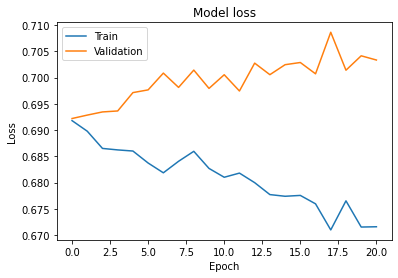

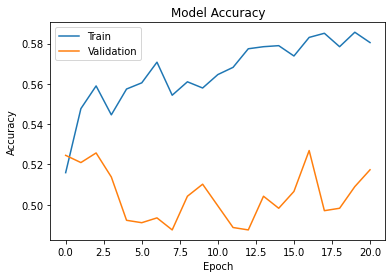

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=False)

lstm_1 = LSTM_1()

lstm_1_history =lstm_1.fit(X_train, y_train,
                           batch_size=16,
                           epochs=100,
                           validation_split=0.3,
                           callbacks=[es])
plot_loss_accuracy(lstm_1_history)

### GRU Layer

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def GRU_1(optimizer='adam', metrics=['accuracy']):
    # Initialisation
    model = Sequential()
    #model.add(layers.GRU(50, activation='tanh'))
    #model.add(layers.GRU(30, activation='tanh'))
    model.add(layers.GRU(100, activation='tanh', dropout=0))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

Epoch 1/100
122/122 [==============================] - 1s 10ms/step - loss: 0.6925 - accuracy: 0.5318 - val_loss: 0.6923 - val_accuracy: 0.5078
Epoch 2/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6928 - accuracy: 0.5349 - val_loss: 0.6946 - val_accuracy: 0.5042
Epoch 3/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6860 - accuracy: 0.5579 - val_loss: 0.6946 - val_accuracy: 0.5018
Epoch 4/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6905 - accuracy: 0.5436 - val_loss: 0.6939 - val_accuracy: 0.5137
Epoch 5/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6850 - accuracy: 0.5610 - val_loss: 0.6990 - val_accuracy: 0.4934
Epoch 6/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6882 - accuracy: 0.5492 - val_loss: 0.7025 - val_accuracy: 0.4898
Epoch 7/100
122/122 [==============================] - 1s 8ms/step - loss: 0.6847 - accuracy: 0.5585 - val_loss: 0.6948 - val_accuracy: 0.514

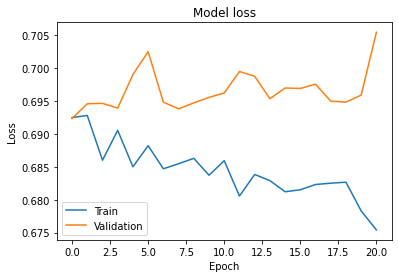

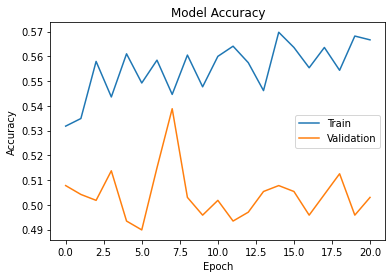

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=False)

GRU_1 = GRU_1()

GRU_1_history = GRU_1.fit(X_train, y_train, 
          batch_size=16, 
          epochs=100, 
          validation_split=0.3,
          callbacks=[es])

plot_loss_accuracy(GRU_1_history)

## Model Evaluation

# Model Improvement